# 시계 multi label classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import random
from PIL import Image

import torch
import torchvision.transforms as T
import timm
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# data

In [3]:
annotations_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/8/data/annotations.csv')
annotations_df

,filename,digit,chronograph,skeleton,jewelry
0,009_cb20cfdd.jpg,0,1,0,0
1,160_fdaf578e.jpg,0,1,0,0
2,133_3096ff30.jpg,0,0,0,0
3,002_10ce6529.jpg,0,1,1,0
4,086_761da09b.jpg,0,1,0,0
...,...,...,...,...,...
619,079_5f66ba04.jpg,0,0,1,0
620,192_96b69d3f.jpg,0,1,1,1
621,169_20ecf901.jpg,0,1,0,1
622,026_3fdbbdc0.jpg,0,0,0,1


# CustomDataset

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, annotations_df, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i in range(annotations_df.shape[0]):
            img_path = os.path.join(root_path, annotations_df.iloc[i, 0])
            labels = annotations_df.iloc[i, 1:].tolist()

            self.data.append((img_path, labels))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        labels = torch.tensor(self.data[idx][1]).float()

        return img, labels

In [5]:
transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])
root_path = '/Users/kimhongseok/cv_79_projects/part1/chapter3/8/data/images'

total_dataset = CustomDataset(root_path, annotations_df, transforms)

In [6]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num+1, valid_num, test_num])

In [7]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

500 62 62


In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# training, evaluation

In [9]:
def training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    total_labels = []
    total_preds = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        preds = (torch.sigmoid(outputs) > threshold).float()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_f1

def evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = (torch.sigmoid(outputs) > threshold).float()

            valid_loss += loss.item()
            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, threshold, num_epochs):
    model.to(device)
    
    for epoch in range(num_epochs):
        model, train_loss, train_f1 = training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs)
        model, valid_loss, valid_f1 = evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train F1: {train_f1}, Valid Loss: {valid_loss}, Valid F1: {valid_f1}')

    return model

# model

In [10]:
model = timm.create_model(
    'efficientnet_b4',
    pretrained=True,
    num_classes=4
)
model

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
    

In [11]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, 0.5, 20)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.6073876980226487, Train F1: 0.2144927122978473, Valid Loss: 0.9086134284734726, Valid F1: 0.3541666666666667


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.25269253621809185, Train F1: 0.6909790479247847, Valid Loss: 0.4781853258609772, Valid F1: 0.3282095263227338


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.13244265876710415, Train F1: 0.8670940354197461, Valid Loss: 0.46723390370607376, Valid F1: 0.2624007936507936


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.08715466817375273, Train F1: 0.9073375271354971, Valid Loss: 0.47699204832315445, Valid F1: 0.2967343976777939


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.06727733585285023, Train F1: 0.9495063827302141, Valid Loss: 0.5371651574969292, Valid F1: 0.2592592592592593


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.060694782208884135, Train F1: 0.9391013277383045, Valid Loss: 0.57840845733881, Valid F1: 0.3736471861471861


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.05427045008400455, Train F1: 0.9443438539540882, Valid Loss: 0.5398569256067276, Valid F1: 0.2874583795782464


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.05239995845477097, Train F1: 0.9757111269385226, Valid Loss: 0.5911015719175339, Valid F1: 0.25765345765345765


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.03490024901839206, Train F1: 0.9763635419910723, Valid Loss: 0.5359048247337341, Valid F1: 0.3475274725274725


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.0401808326569153, Train F1: 0.9710724497218296, Valid Loss: 0.6387284249067307, Valid F1: 0.33520253331574085


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.04906346969073638, Train F1: 0.9519822477667911, Valid Loss: 0.6101410388946533, Valid F1: 0.27629310344827585


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.0684536728222156, Train F1: 0.9661649818806625, Valid Loss: 0.606612965464592, Valid F1: 0.19935064935064933


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.04418275985153741, Train F1: 0.9524365867312321, Valid Loss: 0.5507629364728928, Valid F1: 0.2765804597701149


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.03798497978277737, Train F1: 0.9666895604395604, Valid Loss: 0.5513643696904182, Valid F1: 0.3407407407407408


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.023704936538706534, Train F1: 0.9737515653207591, Valid Loss: 0.5928846746683121, Valid F1: 0.36969696969696964


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.030508518733768142, Train F1: 0.9764548869161043, Valid Loss: 0.5935524106025696, Valid F1: 0.32796610169491525


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.029180478193666204, Train F1: 0.9734134449669654, Valid Loss: 0.597780354321003, Valid F1: 0.33935969868173255


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.03955407525791088, Train F1: 0.972586422221847, Valid Loss: 0.54863391071558, Valid F1: 0.3807471264367816


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.05418664120406902, Train F1: 0.966099278630802, Valid Loss: 0.6875787973403931, Valid F1: 0.24107142857142858


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.05631067216745578, Train F1: 0.9510737401821477, Valid Loss: 0.5976497977972031, Valid F1: 0.2967343976777939


# test

In [12]:
model.eval()
total_preds = []
total_labels = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>0.5).float()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

print(f1_score(total_labels, total_preds, average='macro'))

  0%|          | 0/4 [00:00<?, ?it/s]

0.42167919799498754


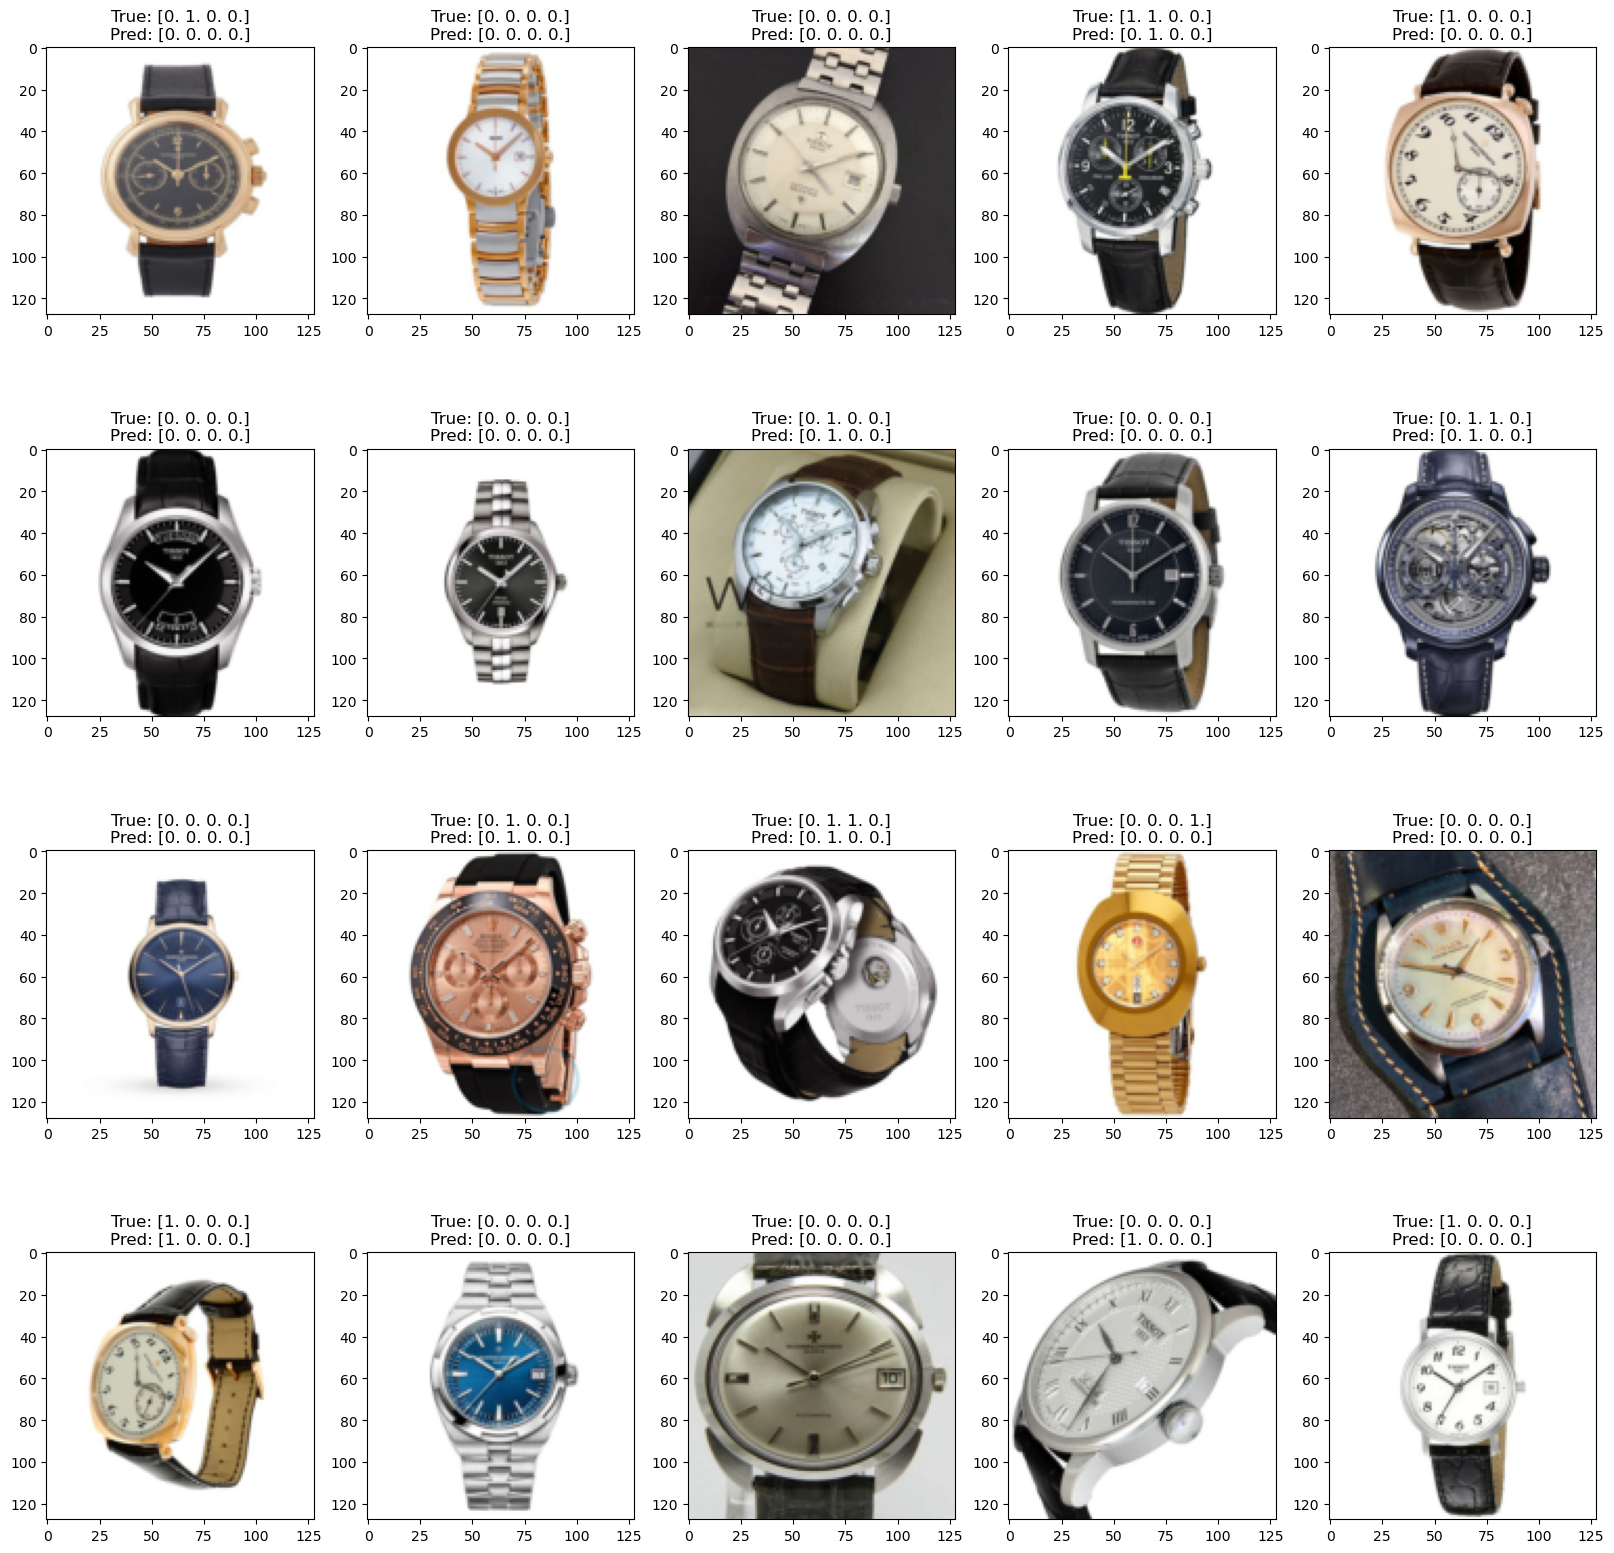

In [16]:
plt.figure(figsize=(20, 20))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {total_labels[i]}\nPred: {total_preds[i]}')